In [16]:
from imports import *
from exactDiagMethods import *
from globalMethods import  *
from vqteMethods import *

In [17]:
N = 5

gamma_L= 4
gamma_R = 4

eps = 1
mu_L= 0.75
mu_R= 3
T_L = 100   
T_R= 10
beta_L=1/T_L
beta_R=1/T_R

F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)

J = 3


eps_list = []

for i in range(N):
    eps_list.append(1)

time = 6.0
dt = 0.3
nt = int(time/dt)

exact_diag_ham = build_exact_diag_hamiltonian(J, eps_list)

ham_real, ham_imag = hamiltonian_generation(N, eps_list, gamma_L, gamma_R, F_L, F_R, J)

vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real)

exact_diag_results, superoperator = perform_exact_diag(gamma_L,F_L, gamma_R, F_R, dt, nt, exact_diag_init_state,exact_diag_ham, N)


In [18]:

"""
Compares the superoperator obtained from exact diagonalization
with the Hamiltonian constructed from VQTE components.

Inputs:
    superoperator : darray - The superoperator from exact diagonalization
    ham_real : SparsePauliOp - The real part of the Hamiltonian from VQTE
    ham_imag : SparsePauliOp - The imaginary part of the Hamiltonian from VQTE

Returns:
    difference : array - The difference between the two matrices
"""
vqte_hamiltonian = ham_real.to_matrix()- 1j * ham_imag.to_matrix()
difference = superoperator + (1j*vqte_hamiltonian)
print("Difference between superoperator and VQTE Hamiltonian:\n", difference)
print("Norm of the difference:", np.linalg.norm(difference))


Difference between superoperator and VQTE Hamiltonian:
 [[ 0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j ...
   0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j]
 [ 0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j ...
   0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j]
 [ 0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j ...
   0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j]
 ...
 [ 0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j ...
  -4.4408921e-16+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j]
 [ 0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j ...
   0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j]
 [ 0.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j ...
   0.0000000e+00+0.j  0.0000000e+00+0.j -4.4408921e-16+0.j]]
Norm of the difference: 1.0048591735576161e-14


Norm of Hamiltonian part difference: 4.5108132682599535
Norm of Dissipative part difference: 4.5108132682599535


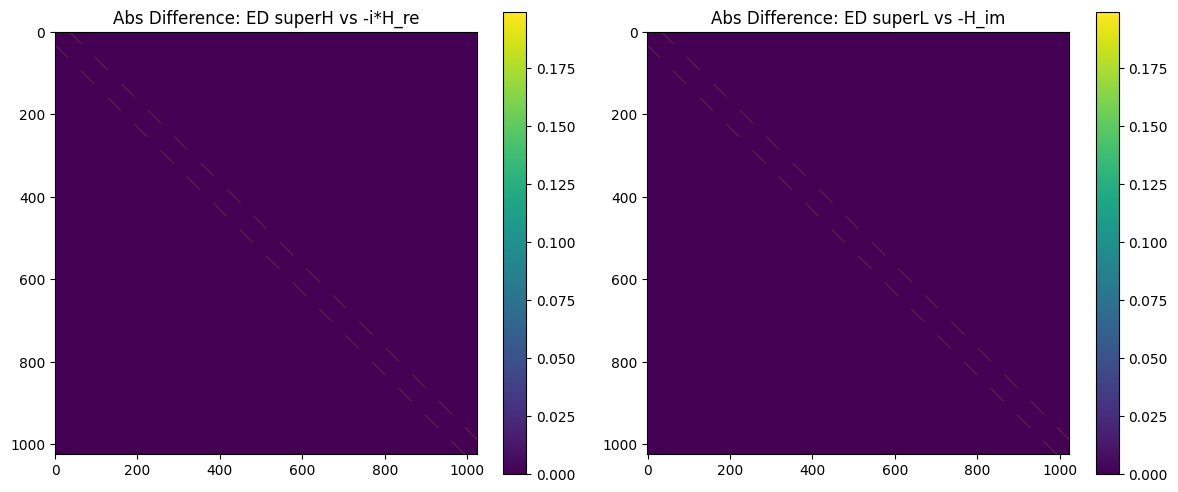

In [ ]:
"""
    Builds superoperators from kron products and compares them against reference 
    real / imag exact matricies
    
    
    
    """
    #Hilbert space size
d = len(exact_diag_ham)

L_K = [ ##Operators 

    np.sqrt(gamma_L*F_L) * Enlarge_Matrix_site_j(0, N, Sigma_minus),
    np.sqrt(gamma_L*(1-F_L)) * Enlarge_Matrix_site_j(0, N, Sigma_plus),
    np.sqrt(gamma_R*(1-F_R)) * Enlarge_Matrix_site_j(N-1, N, Sigma_plus),
    np.sqrt(gamma_R*F_R) * Enlarge_Matrix_site_j(N-1, N, Sigma_minus)

]
##Construct superop
superH = -1j * (np.kron(np.eye(d), exact_diag_ham) - np.kron(exact_diag_ham.T, np.eye(d)))

superL = sum([np.kron(L.conjugate(), L)
              #jump term
              - 0.5 * (np.kron(np.eye(d), L.conjugate().T @ L) +
                #decay
                       np.kron(L.T @ L.conjugate(), np.eye(d))) for L in L_K])


mat_re = ham_real.to_matrix()
mat_im = ham_imag.to_matrix()


diff_re = superH - (-1j * mat_re)
diff_im = superL - (-1 * mat_im) # check signs


print(f"Norm of Hamiltonian part difference: {np.linalg.norm(diff_re)}")
print(f"Norm of Dissipative part difference: {np.linalg.norm(diff_im)}")


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


im1 = axes[0].imshow(np.abs(diff_re), cmap='viridis')
axes[0].set_title("Abs Difference: ED superH vs -i*H_re")

plt.colorbar(im1, ax=axes[0])


im2 = axes[1].imshow(np.abs(diff_im), cmap='viridis')

axes[1].set_title("Abs Difference: ED superL vs -H_im")

plt.colorbar(im2, ax=axes[1])
plt.tight_layout()
plt.show()



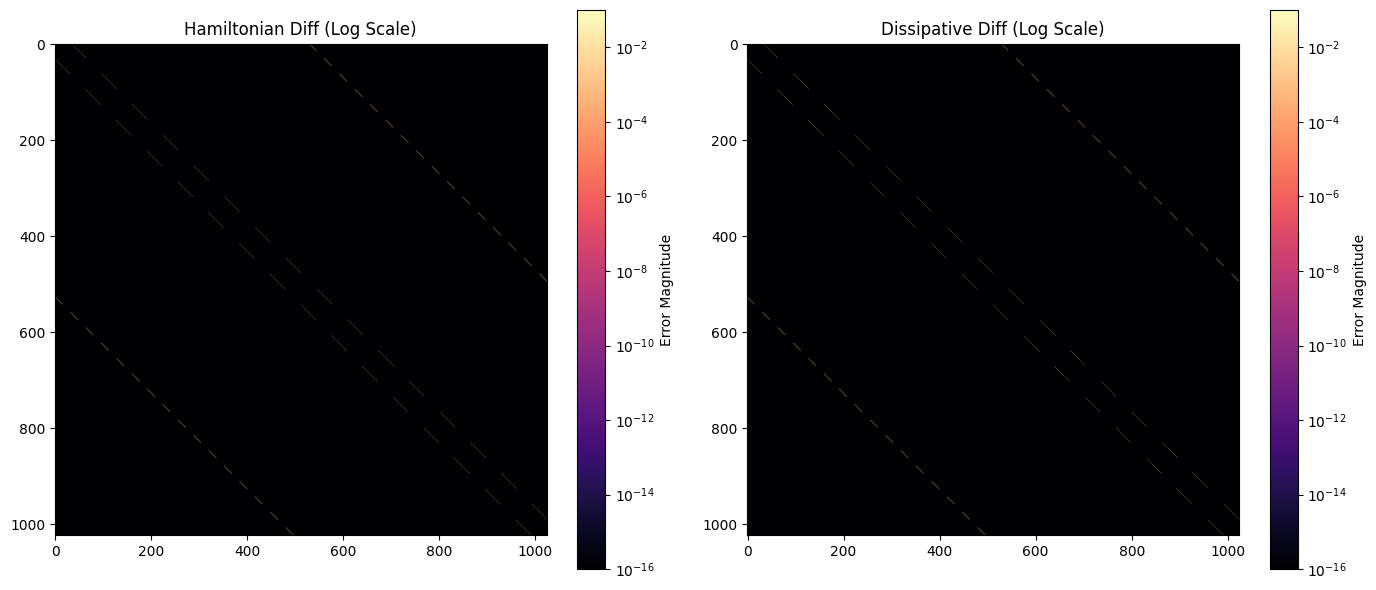

Total Hamiltonian Error (Norm): 4.51e+00
Total Dissipative Error (Norm): 4.51e+00


In [ ]:
"""
Calculates diff between superoperators and exact matricies. But in log form

Deep Purple/Black: Perfect match (near machine epsilon).
Faint Dotted Lines: Normal numerical noise from Kronecker products.
Bright Solid Lines: Logic mismatch (check your J or Gamma factors).
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# --- 1. DIMENSION & OPERATOR SETUP ---
# d is the Hilbert space dimension (2^N)
d = len(exact_diag_ham)

# Constructing the Jump Operators for the Reservoirs
L_K = [
    np.sqrt(gamma_L*F_L) * Enlarge_Matrix_site_j(0, N, Sigma_minus),
    np.sqrt(gamma_L*(1-F_L)) * Enlarge_Matrix_site_j(0, N, Sigma_plus),
    np.sqrt(gamma_R*(1-F_R)) * Enlarge_Matrix_site_j(N-1, N, Sigma_plus),
    np.sqrt(gamma_R*F_R) * Enlarge_Matrix_site_j(N-1, N, Sigma_minus)
]

superH = -1j * (np.kron(np.eye(d), exact_diag_ham) - np.kron(exact_diag_ham.T, np.eye(d)))

# Dissipative part 
superL = sum([np.kron(L.conjugate(), L) 
              - 0.5 * (np.kron(np.eye(d), L.conjugate().T @ L) +
                       np.kron(L.T @ L.conjugate(), np.eye(d))) for L in L_K])


mat_re = ham_real.to_matrix()
mat_im = ham_imag.to_matrix()

# Compute the absolute differences

diff_re = np.abs(superH - (-1j * mat_re))
diff_im = np.abs(superL - (-1 * mat_im))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Define the Log Scale: 1e-16 is our "Zero" (purple), 1.0 is "Huge Error" (yellow)
log_norm = colors.LogNorm(vmin=1e-16, vmax=1e-1)

# Plot Real (Hamiltonian) Difference
im1 = axes[0].imshow(diff_re + 1e-17, cmap='magma', norm=log_norm)
axes[0].set_title("Hamiltonian Diff (Log Scale)")
plt.colorbar(im1, ax=axes[0], label='Error Magnitude')

# Plot Imaginary (Dissipative) Difference
im2 = axes[1].imshow(diff_im + 1e-17, cmap='magma', norm=log_norm)
axes[1].set_title("Dissipative Diff (Log Scale)")
plt.colorbar(im2, ax=axes[1], label='Error Magnitude')

plt.tight_layout()
plt.show()

# Print the final validation scores
print(f"Total Hamiltonian Error (Norm): {np.linalg.norm(diff_re):.2e}")
print(f"Total Dissipative Error (Norm): {np.linalg.norm(diff_im):.2e}")

Make operators into quantum circut. Brute force but (It could work)
Compose it in a quantum transpiler

## Email joaquin / hirad

## Erase from computer

Start a doc for tasks for this week 

Physical Review A[]

In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def compare_superoperators(matrix_a, matrix_b, title_a="Manual", title_b="Reference"):
    """
    Plots the absolute difference between the Real and Imaginary parts 
    of two superoperators to identify indexing or sign errors.
    """
    # Calculate differences
    diff_real = np.abs(np.real(matrix_a) - np.real(matrix_b))
    diff_imag = np.abs(np.imag(matrix_a) - np.imag(matrix_b))
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Use LogNorm to highlight errors across many scales
    # 1e-16 is roughly machine precision (perfect match)
    norm = colors.LogNorm(vmin=1e-16, vmax=1)
    cmap = 'magma' 

    # Plot Real Part Difference
    im1 = axes[0].imshow(diff_real + 1e-18, cmap=cmap, norm=norm)
    axes[0].set_title(f"Real Part Difference\n({title_a} vs {title_b})")
    plt.colorbar(im1, ax=axes[0], label='Absolute Error (Log)')

    # Plot Imaginary Part Difference
    im2 = axes[1].imshow(diff_imag + 1e-18, cmap=cmap, norm=norm)
    axes[1].set_title(f"Imaginary Part Difference\n({title_a} vs {title_b})")
    plt.colorbar(im2, ax=axes[1], label='Absolute Error (Log)')

    plt.tight_layout()
    plt.show()

# Example Usage for your Hamiltonian part:
# compare_superoperators(superH, -1j * mat_re, "superH", "-i*mat_re")

# Example Usage for your Dissipative part:
# compare_superoperators(superL, -1 * mat_im, "superL", "-mat_im")